In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["SURVEYSIM_PATH"] = "/home/fforster/Work/surveysim"
sys.path.append("%s/lib" % os.environ["SURVEYSIM_PATH"])

if not os.path.exists("plots"):
    os.makedirs("plots")

In [3]:
from constants import *
from obsplan import *
from LCz import *
from LCz_Av import *
from LCz_Av_params import *
from SFHs import *
from survey_multimodel import *

# Cosmology stuff                                                                                                                                     
import cos_calc

/home/fforster/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# filtername                                                                                                                                      
modelname = "Hsiao"
obsname = "Blanco-DECam" #"CFHT-MegaCam" #Blanco-DECam" #"KMTNet"

Observation plan name: Field47-nf1-ne1-nr5-nn35_Blanco-DECam_gir
Computing moon phase and sky magnitudes for band g
Computing moon phase and sky magnitudes for band i
Computing moon phase and sky magnitudes for band r
Computing limiting magnitudes for all bands (this may take some time)
Plotting observational plan


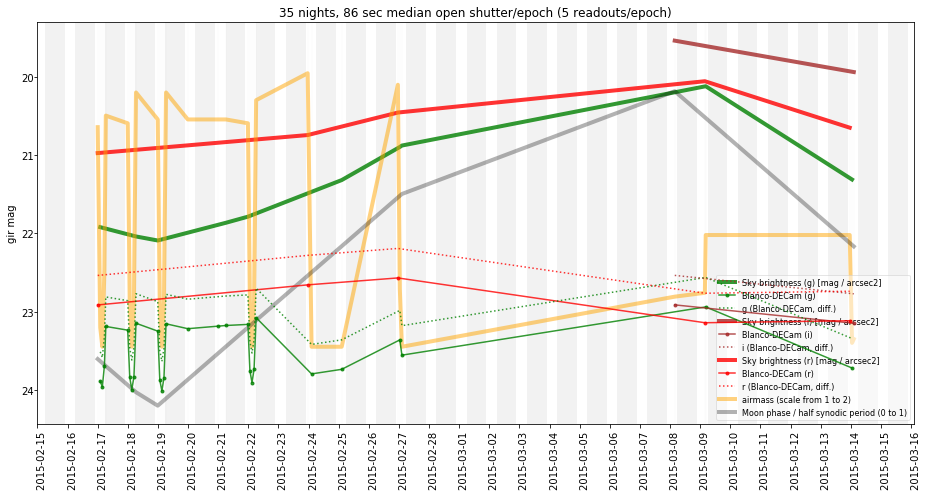

In [5]:
# start an observational plan                                                                                                                     
plan = obsplan(obsname = obsname, mode = 'file-cols', inputfile = "Field47.dat", \
               nfields = 1, nepochspernight = 1, nightfraction = 0.045, nread = 5, doplot = True, \
               doload = False, bandcolors = {'g': 'g', 'r':'r', 'i': 'brown'})

In [6]:
# load models     
modelsdir = "models" 
modelfile = "snflux_1a.dat"
files = np.array([modelfile], dtype = str)
params = np.array([1., 1.])[:, np.newaxis]

In [7]:
# Redshift, Avs and time grids                                                                                                                                                                                        
nz = 30
ntimes = 100
nAvs = 10
zs = np.logspace(-3, 0, nz)
times = np.logspace(-3, 3, ntimes)
Avs = np.logspace(-4, 1, nAvs)
Rv = 3

In [8]:
# initialize LCz_Av_params models 
# For the Hsiao models there are no parameters to be interpolated from a grid of models
paramnames = ["scale", "stretch"]
paramunits = ["", ""]
LCs = LCz_Av_params(modelsdir = modelsdir, modelname = modelname, \
                    files = files, paramnames = paramnames, paramunits = paramunits, params = params, \
                    zs = zs, Avs = Avs, Rv = Rv, times = times, dostretch = True)

In [9]:
# do cosmology                                                                                                                                                                                                  
LCs.docosmo()

Here we compute the models. This can be VERY slow the first time and may require using a cluster for speed up (load = False, save = True)

In [10]:
# compute models in given bands                                                                                                                                                                                 
if plan.obsname in ["Blanco-DECam"]:
    LCs.compute_models(bands = ['u', 'g', 'r', 'i', 'z'], obsname = obsname, load = True)#, save = True)#, 'r'])#, 'i', 'z'])                                                                                                      
elif plan.obsname in ["KMTNet"]:
    LCs.compute_models(bands = ['g', 'B', 'V', 'R', 'I'], obsname = obsname, load = True)#False, save = True)#, 'r'])#, 'i', 'z'])                                                                                                 
elif plan.obsname in ["CFHT-MegaCam"]:
    LCs.compute_models(bands = ['g', 'r', 'i', 'z'], obsname = obsname, load = True)#False, save = True)#, 'r'])#, 'i', 'z'])                                                                                                 
else:
    print("What bands to use?")

In [11]:
# set metric
parammetric = np.array([1.])
paramlogscale = np.array([False], dtype = bool)
LCs.setmetric(metric = parammetric, logscale = paramlogscale)

In [12]:
# set observations                                                                                                                                                                                              
if plan.obsname in ["Blanco-DECam", "CFHT-MegaCam"]:
    LCs.set_observations(mjd = plan.MJDs, flux = None, e_flux = None, filters = plan.bands, objname = None, plot = False, bandcolors = {'g': 'g', 'r': 'r', 'i': 'brown', 'z': 'k'})
elif plan.obsname in ["KMTNet"]:
    LCs.set_observations(mjd = plan.MJDs, flux = None, e_flux = None, filters = plan.bands, objname = None, plot = False, bandcolors = {'g': 'gray', 'B': 'b', 'V': 'g', 'R': 'r', 'I': 'brown'})
else:
    print("What bands to use?")

In [13]:
# star formation                                                                                                                                                                                                
SFH = SFHs(SFH = 'Ia-P12')
efficiency = 1.

In [14]:
# maximum age of object at the start of the survey
maxrestframeage = 5

Start a new survey!

This combines an observational plan, a star formation history, an efficiency, a LCz_Av_params object and a maximum rest frame age

In [15]:
# start survey                                                                                 
newsurvey = survey_multimodel(obsplan = plan, SFH = SFH, efficiency = efficiency, LCs = LCs, maxrestframeage = maxrestframeage)

Set the maximum redshift for the simulation. The larger the more computationally expensive. This can be done automatically, but can be slow

In [16]:
# set maximum redshift                                                                                                                                                                                          
newsurvey.set_maxz(0.7)

Do cosmology at the redshift grid used for the survey object

In [17]:
# do cosmology with dense grid
newsurvey.do_cosmology()

Set the distribution of physical parameters, as distributions which return distributions of variables defined in rvs and bounds for the same random variables

In [18]:
# set distribution of physical parameters                                                                                                                                                                       
minMJD, maxMJD = min(newsurvey.obsplan.MJDs) - (20. + newsurvey.maxrestframeage) * (1. + max(newsurvey.zs)), max(newsurvey.obsplan.MJDs)
rvs = { 'texp': lambda nsim: uniform.rvs(loc = minMJD, scale = maxMJD - minMJD, size = nsim), \
        'logAv': lambda nsim: norm.rvs(loc = np.log(0.1), scale = 1., size = nsim), \
        'scale': lambda nsim: norm.rvs(loc = 1., scale = 0.3, size = nsim), \
        'stretch': lambda nsim: norm.rvs(loc = 1., scale = 0.3, size = nsim)}
bounds = {'texp': [minMJD, maxMJD], \
        'logAv': [np.log(1e-4), np.log(10.)], \
        'scale': [0.1, 10.], \
        'stretch': [0.1, 10.]}

Set default physical parameters

In [19]:
# default intrinsic physical values (None for those which will be randomly sampled)
scale = None
stretch = None
pars = np.array([scale, stretch]) # must be in same order as paramnames

Sample events using the previous distributions to generate light curves. 

Note that they are sampled from the expected distribution up to the maximum redshift chosen, which gives very few low redshift SNe (as in nature).

Sample 9990

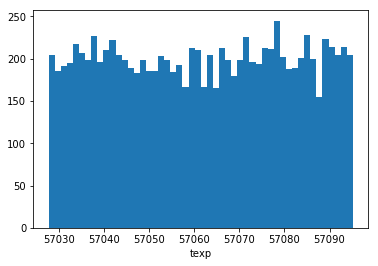

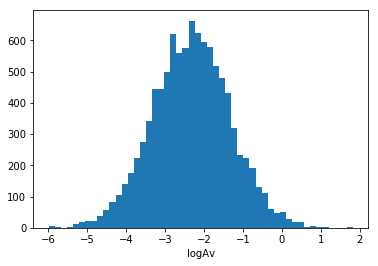

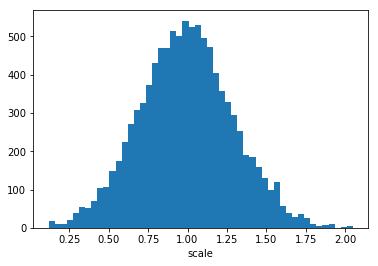

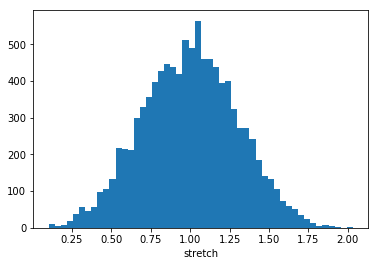

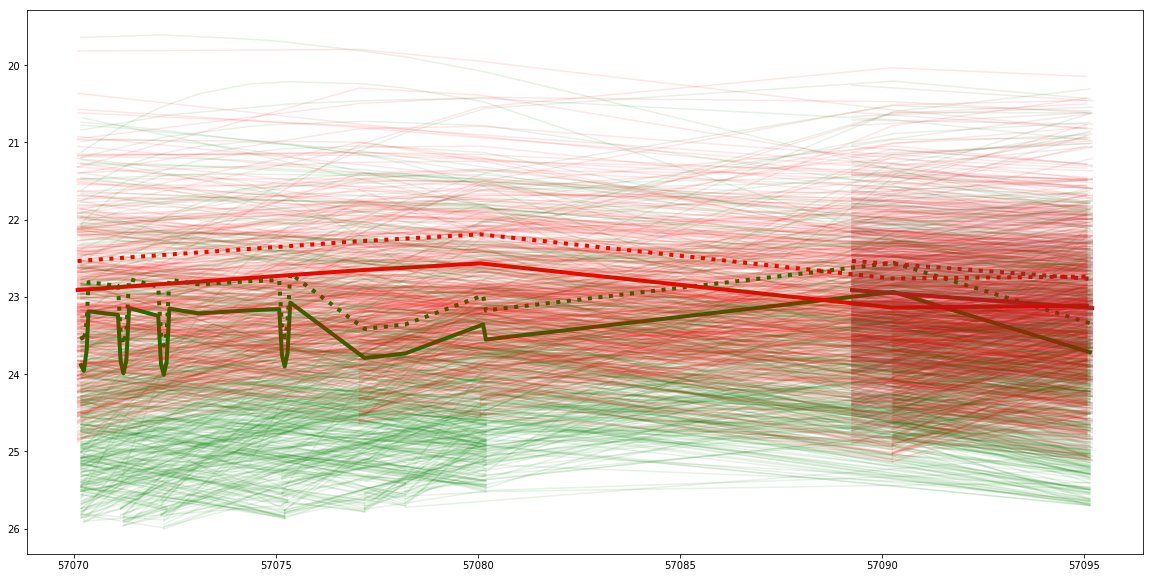

In [20]:
nsim = 10000
newsurvey.sample_events(nsim = nsim, doload = False, doplot = True, doemergence = False, \
                              rvs = rvs, bounds = bounds, pars = pars)

Measure the efficiency of detection and the cumulative number of events as a function of redshift and other physical parameters.

This part has many variables hard coded and will need to be generalized

/home/fforster/Work/surveysim/lib/survey_multimodel.py:521: RuntimeWarning: invalid value encountered in true_divide
  self.y_effs[vallabel] = 1. * nout / nin


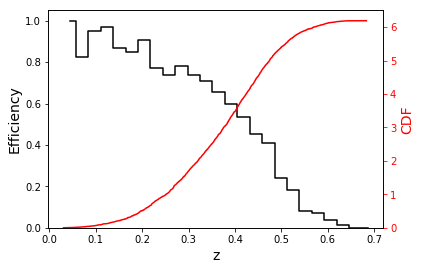

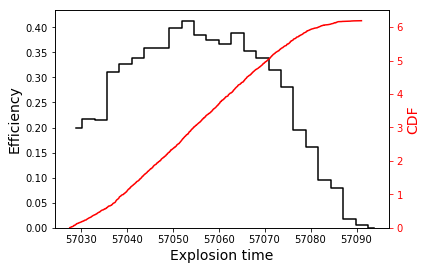

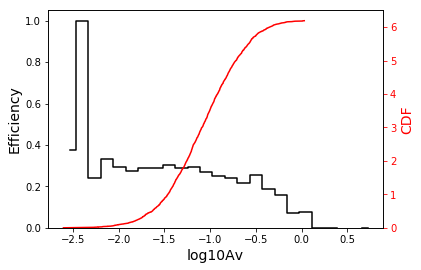

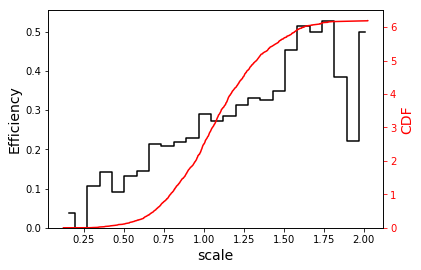

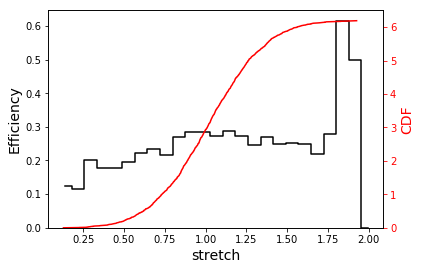

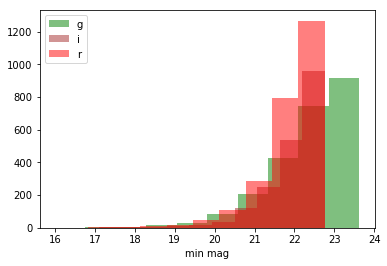

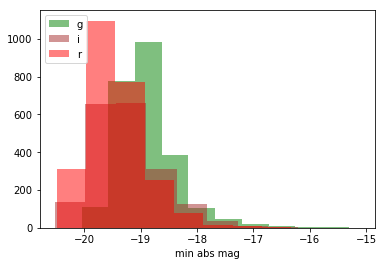

In [21]:
# measure detections and efficiency                                                                                                                                                                             
newsurvey.do_efficiency(doplot = True, verbose = False, check1stdetection = False)